In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from random import random
from src.io_utils import *

In [2]:
import os

In [3]:
from src.LightCurve import LightCurve

### Load data

In [4]:
path_perfect_sims_phot = "/sps/lsst/users/bbiswas/data/kilonova_datasets/RESSPECT/RESSPECT_PERFECT_LIGHTCURVE_WITH_KN.csv"
path_perfect_sims_head = "/sps/lsst/users/bbiswas/data/kilonova_datasets/RESSPECT/RESSPECT_PERFECT_HEAD_WITH_KN.csv"

In [5]:
data_ob = load_RESSPECT_data(phot_df_file_path=path_perfect_sims_phot, meta_df_file_path=path_perfect_sims_head)


In [6]:
from src.Generate_PC_utils import get_event_distirb

In [7]:
event_distrib = get_event_distirb(data_ob)
print(event_distrib)

{'Ibc_V19': 1000, 'IIn': 689, 'Ia': 3000, 'II_V19': 1000, 'II-NMF': 1000, '91bg': 863, 'Iax': 1000, 'Ibc-MOSFIT': 421, 'KN': 1000}


In [8]:
from kndetect.utils import get_data_dir_path

In [9]:
data_dir = get_data_dir_path()

### Filter objects with readings every 2 days

In [10]:
from src.Generate_PC_utils import get_ids_of_eqally_spaced_objects

In [11]:
#equally_spaced_ids = get_ids_of_eqally_spaced_objects(data_ob)
#event_distrib = get_event_distirb(data_ob, equally_spaced_ids)
#print(event_distrib)

In [12]:
#np.save(data_dir+"equally_spaced_ids", equally_spaced_ids)

In [13]:
equally_spaced_ids = np.load(data_dir+"equally_spaced_ids.npy")
event_distrib = get_event_distirb(data_ob, equally_spaced_ids)
print(event_distrib)

{'Ibc_V19': 584, 'IIn': 381, 'II_V19': 567, 'II-NMF': 621, 'Iax': 601, 'Ia': 849, '91bg': 558, 'Ibc-MOSFIT': 248, 'KN': 1000}


# Generating PCs for non-KN events

In [14]:
use_only_KN_events = False
save_results = True

### Create train data with specific distribution of Data

In [15]:
from src.Generate_PC_utils import get_ids_for_target_distrib

In [16]:
target_distrib = {'91bg': 125, 'II-NMF': 125, 'II_V19': 125, 'IIn': 125, 'Ia': 125, 'Iax': 125, 'Ibc-MOSFIT': 125, 'Ibc_V19': 125, 'KN': 1000}

In [17]:
target_ids = get_ids_for_target_distrib(data_ob, target_distrib, equally_spaced_ids)
event_distrib = get_event_distirb(data_ob, target_ids)
print(event_distrib)

{'II-NMF': 125, 'II_V19': 125, '91bg': 125, 'Iax': 125, 'Ibc_V19': 125, 'KN': 1000, 'Ia': 125, 'IIn': 125, 'Ibc-MOSFIT': 125}


### Generate PCS

In [18]:
from src.Generate_PC_utils import stack_training_data, gen_components

In [19]:
train_data = stack_training_data(data_ob, object_ids=target_ids, num_days_tolerance=2, plot_results=False)
plt.close('all')

In [20]:
if save_results:

    np.save(data_dir+"/PC_generation_dataset_mixed.npy", train_data)

In [21]:
PC_dict, PC_var_ratio = gen_components(train_data)
print(PC_var_ratio)
band = 'all'
PCs= PC_dict[band]

(4000, 51)
{'all': array([8.72569059e-01, 4.69688892e-02, 4.37735881e-02, 2.12770799e-02,
       8.19753034e-03, 2.26301862e-03, 1.70288467e-03, 8.19220639e-04,
       7.33780930e-04, 5.47431507e-04])}


all band


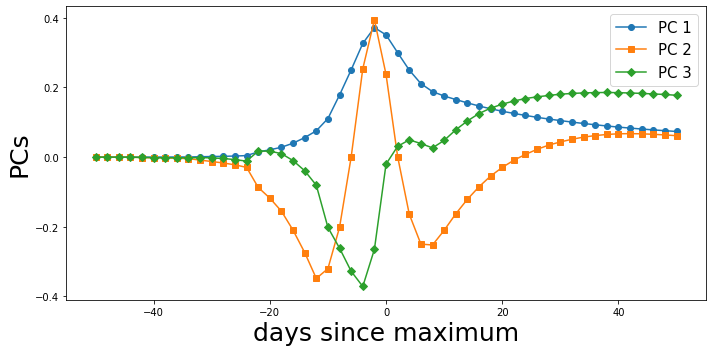

In [22]:
markers = ['o','s','D','*','x']

band = 'all'

print(band+ " band")
PCs= PC_dict[band]
fig = plt.figure(figsize=(10,5))
for i in range(3):
    PC = PCs[i]
    x = np.arange(0,102,2)-50
    plt.plot(x,PC,marker=markers[i],label = "PC "+str(i+1))

plt.xlabel("days since maximum", fontsize = 25)
plt.ylabel("PCs", fontsize=25)

plt.rc('xtick', labelsize=17)    
plt.rc('ytick', labelsize=17) 

plt.rc('legend', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
if save_results:

        np.save(data_dir+'/pc_var_ratio_mixed_pcs.npy', PC_var_ratio)
        np.save(data_dir+"/mixed_pcs",PC_dict)

# Now interpolate

In [24]:
import matplotlib.pyplot as plt
from src.io_utils import get_pcs

In [25]:
num_pc_components=3
bands=['g','r']

In [26]:
pcs = get_pcs(num_pc_components, pcs_choice='non-interpolated', normalize_pcs=False)

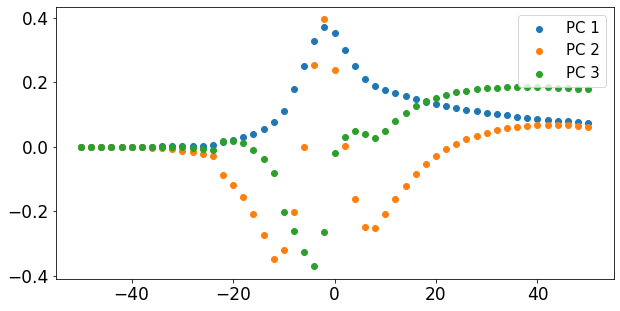

In [27]:
import numpy as np
fig = plt.figure(figsize=(10,5))

for i in range(num_pc_components):
    PC = pcs[i]
    x = np.arange(0,102,2)-50
    plt.scatter(x,PC,label = "PC "+str(i+1))
plt.legend()

In [28]:
x = np.linspace(-50, 50, num=51, endpoint=True)
xnew = np.linspace(-50, 50, num=401, endpoint=True)

In [29]:
np.shape(x)

(51,)

In [30]:
from scipy.interpolate import interp1d
PC_inter_func = []

PC_new=[]
for i in range(3):
    func = interp1d(x, pcs[i], kind='quadratic')
    PC_inter_func.append(func)
    PC_new.append(func(xnew))

In [31]:
PC_new = np.array(PC_new)

In [32]:
np.shape(PC_new)

(3, 401)

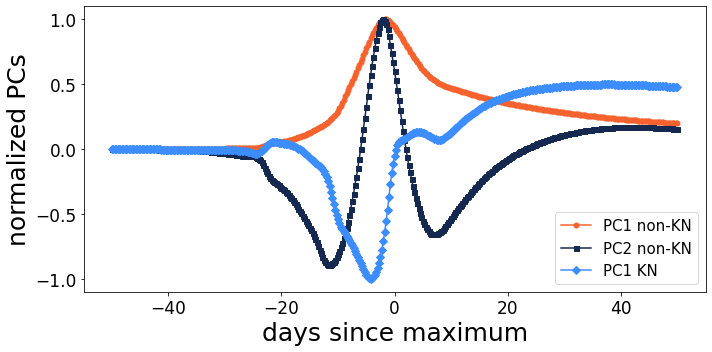

In [33]:
import numpy as np
fig = plt.figure(figsize=(10,5))
pc_names = ["PC1 non-KN", "PC2 non-KN", "PC1 KN"]
colors = ['#F5622E', '#15284F', '#3C8DFF'] 
markers = ['o','s','D','*','x']
for i in range(num_pc_components):
    max_val = np.amax(np.abs(PC_new[i]))
    PC_new[i] = PC_new[i]/max_val
    PC = PC_new[i]
    plt.plot(xnew,PC,label = pc_names[i], marker=markers[i], ms=5, color=colors[i])
plt.xlabel("days since maximum", fontsize=25)
plt.ylabel("normalized PCs", fontsize=25)
ax = plt. gca()

leg = ax.legend()

plt.rc('xtick', labelsize=17)    
plt.rc('ytick', labelsize=17) 

plt.rc('legend', loc='lower right', fontsize=15)
plt.legend()
plt.tight_layout()
#plt.savefig("results/PC_plots/interpolated_pcs.pdf")

In [34]:
np.save(data_dir+'/interpolated_mixed_pcs.npy', PC_new)

In [35]:
pcs = get_pcs(num_pc_components, pcs_choice='interpolated', normalize_pcs=False)